___

In [60]:
# Import libraries to be used

# Warning messages display
# import warnings
# warnings.filterwarnings(action='once') # https://docs.python.org/3/library/warnings.html#the-warnings-filter

# Directories/Files management
import os.path
## from zipfile import ZipFile # De momento no ha hecho falta 

# Timing
import time

# Data analysis and wrangling
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Show all columns in DataFrames
pd.set_option('display.max_rows', 100) # If too high, it greatly slows down the output display and freezes the kernel


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot') # choose a style: 'plt.style.available'
sns.set_theme(context='notebook',
              style="darkgrid") # {darkgrid, whitegrid, dark, white, ticks}
palette = sns.color_palette("flare", as_cmap=True);
import altair as alt

# Machine Learning
## from sklearn.[...] import ...

In [61]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [62]:
t0 = time.perf_counter() 

In [63]:
# Detect Operating System running and manage paths accordingly

if os.name == 'nt': # Windows
    root = r"C:\Users\turge\CompartidoVM\0.TFM"
    print("Running on Windows.")
elif os.name == 'posix': # Ubuntu
    root = "/home/dsc/shared/0.TFM"
    print("Running on Ubuntu.")
print("root path\t", root)

Running on Windows.
root path	 C:\Users\turge\CompartidoVM\0.TFM


___

## 1. Load the dataset

In [64]:
cols = [
     'MONTH',
     'DAY_OF_MONTH',
     'DAY_OF_WEEK',
     'OP_UNIQUE_CARRIER',
# For the time being, 'TAIL_NUM' will be disregarded due to its high cardinality  (~ 4500) and low expected added value    
#      'TAIL_NUM',
     'ORIGIN', # Let's skip this feature to prevent high cardinality and check if it's relevant or not
     'DEST', # Let's skip this feature to prevent high cardinality and check if it's relevant or not
#      'CRS_DEP_TIME', # Redundant having the 'DEP_ARR_hour' feature
     'DEP_TIME_hour',
#      'DEP_TIME',
#      'DEP_DELAY',
#      'DEP_DEL15',
#      'TAXI_OUT',
     'TAXI_OUT_median',
#      'TAXI_IN',
     'TAXI_IN_median',
#      'CRS_ARR_TIME', # Redundant having the 'ARR_ARR_hour' feature
     'ARR_TIME_hour', 
#      'ARR_TIME',   
#      'ARR_DELAY',
     'ARR_DEL15', # → Target !!
#      'CANCELLED',
     'CRS_ELAPSED_TIME',
     'DISTANCE',
     'DISTANCE_GROUP',
#      'CARRIER_DELAY',
#      'WEATHER_DELAY',
#      'NAS_DELAY',
#      'SECURITY_DELAY',
#      'LATE_AIRCRAFT_DELAY',
]

In [65]:
preprocessed_input_csv_path = os.path.join(root,
                                           "Output_Data",
                                           "US_DoT",
                                           "AL_OTP_MVP_Preprocessed_19_v2_clean.csv")
preprocessed_input_csv_path

'C:\\Users\\turge\\CompartidoVM\\0.TFM\\Output_Data\\US_DoT\\AL_OTP_MVP_Preprocessed_19_v2_clean.csv'

In [66]:
cols_dtypes = {
               'MONTH' : 'category',
               'DAY_OF_MONTH' : 'category',
               'DAY_OF_WEEK' : 'category',
               'OP_UNIQUE_CARRIER' : 'category',
               'ORIGIN' : 'category',
               'DEST' : 'category',
               'DEP_TIME_hour' : 'category',
               'TAXI_OUT_median' : 'int64',
               'TAXI_IN_median' : 'int64',
               'ARR_TIME_hour' : 'category', 
               'ARR_DEL15' : 'int32', # → Target !!
               'CRS_ELAPSED_TIME' : 'int64',
               'DISTANCE' : 'int64',
               'DISTANCE_GROUP' : 'category'
               }

In [67]:
%%time

df_all = pd.read_csv(preprocessed_input_csv_path,
                     encoding='latin1',
                     usecols=cols,
                     low_memory = False)

Wall time: 25.3 s


In [68]:
# Cast types in accordance to previously defined dictionary:
df_all = df_all.astype(cols_dtypes)
# Display DF columns according to 'cols' order:
df_all = df_all[cols]
df_all

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_hour,TAXI_OUT_median,TAXI_IN_median,ARR_TIME_hour,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
0,1,3,4,9E,TYS,ATL,11,15,8,12,1,70,152,1
1,1,4,5,9E,TYS,ATL,11,15,8,12,1,70,152,1
2,1,5,6,9E,ATL,SGF,9,17,5,10,0,121,563,3
3,1,6,7,9E,ATL,SGF,9,17,5,10,0,123,563,3
4,1,7,1,9E,ATL,SGF,9,17,5,10,0,123,563,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268227,12,31,2,B6,MCO,SWF,13,15,6,16,1,163,989,4
7268228,12,31,2,B6,DCA,BOS,14,15,6,15,0,90,399,2
7268229,12,31,2,B6,PHL,BOS,7,17,6,8,0,85,280,2
7268230,12,31,2,B6,BOS,SJU,8,16,5,13,0,242,1674,7


In [69]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7268232 entries, 0 to 7268231
Data columns (total 14 columns):
 #   Column             Dtype   
---  ------             -----   
 0   MONTH              category
 1   DAY_OF_MONTH       category
 2   DAY_OF_WEEK        category
 3   OP_UNIQUE_CARRIER  category
 4   ORIGIN             category
 5   DEST               category
 6   DEP_TIME_hour      category
 7   TAXI_OUT_median    int64   
 8   TAXI_IN_median     int64   
 9   ARR_TIME_hour      category
 10  ARR_DEL15          int32   
 11  CRS_ELAPSED_TIME   int64   
 12  DISTANCE           int64   
 13  DISTANCE_GROUP     category
dtypes: category(9), int32(1), int64(4)
memory usage: 325.8 MB


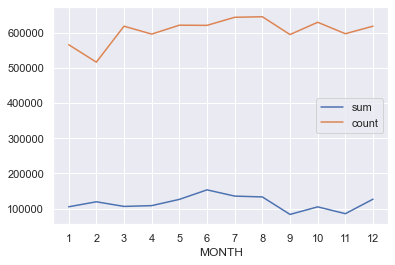

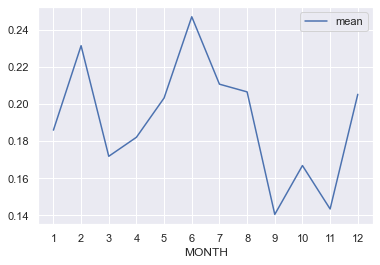

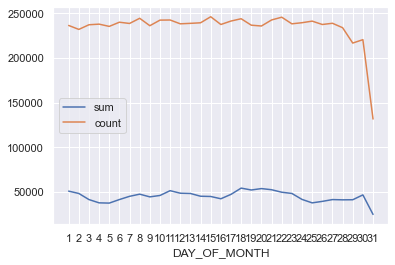

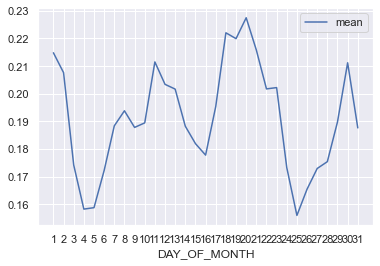

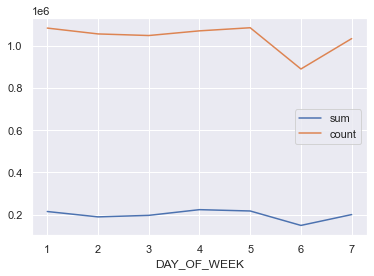

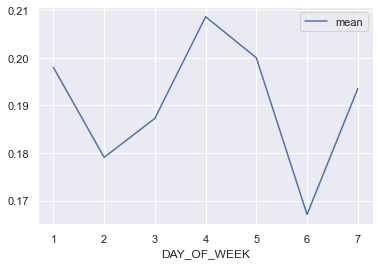

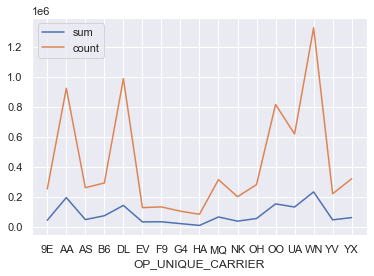

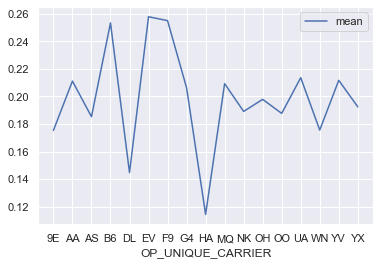

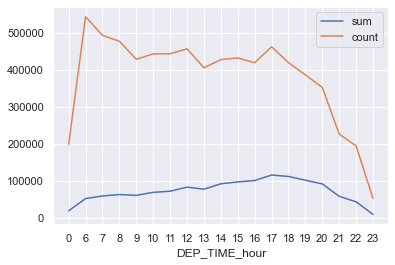

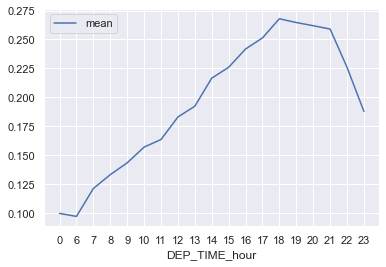

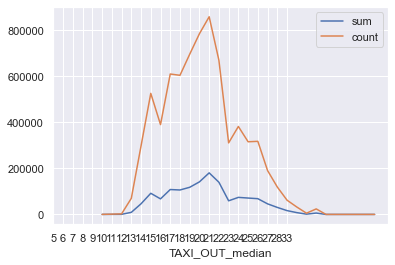

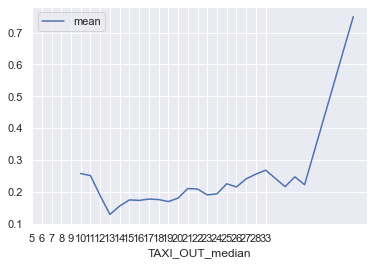

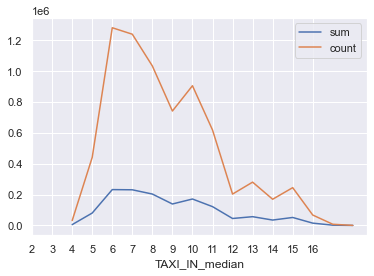

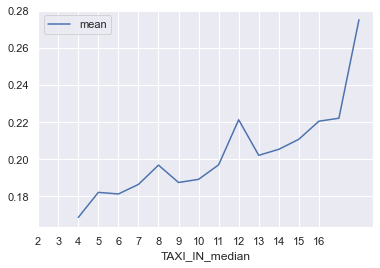

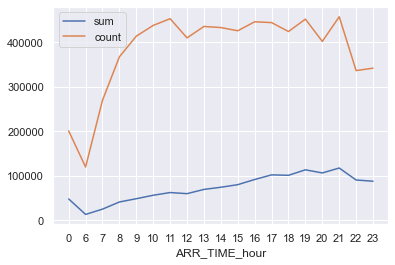

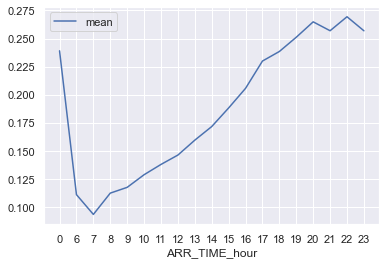

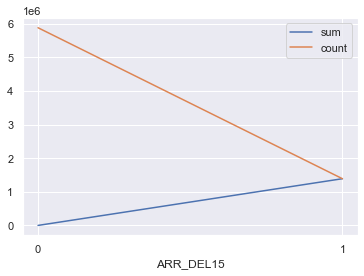

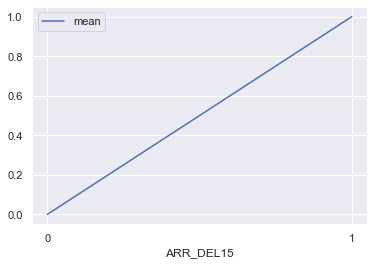

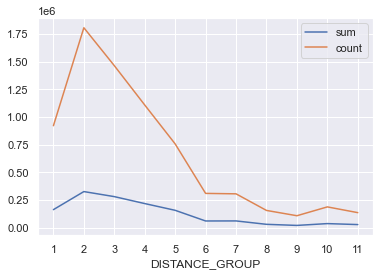

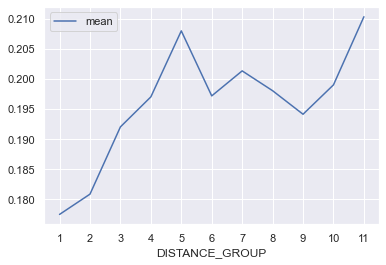

In [70]:
features = [col for col in df.columns if col not in ['ORIGIN', 'DEST','CRS_ELAPSED_TIME', 'DISTANCE']]

for f in features:
    grp1 = df_all.groupby(f)['ARR_DEL15'].agg(['sum', 'count'])
    grp2 = df_all.groupby(f)['ARR_DEL15'].agg(['mean'])
    ticks=range(len(list(grp1.index)))
    labels=list(grp1.index)
    grp1.plot();
    plt.xticks(ticks=ticks, labels=labels);
    grp2.plot();
    plt.xticks(ticks=ticks, labels=labels);

In [71]:
# from pandas_profiling import ProfileReport

# # # Complete report:
# # prof = ProfileReport(df_all)
# # prof.to_file('informe.html')

# # Sample report (more computationally efficient)
# prof = ProfileReport(df_all.sample(10000)) 
# prof.to_file('sample_report.html')

In [72]:
# from pandas_profiling import ProfileReport

# # Complete report:
# prof = ProfileReport(df_all, minimal=True)
# prof.to_file('complete_report.html')

# # # Sample report (more computationally efficient)
# # prof = ProfileReport(df_all.sample(10000)) 
# # prof.to_file('sample_report.html')

## 2. Dataset overview

In [73]:
# For the initial runs, define a reasonably-sized sample:
sample_length = int(1e5)

# The dataset is somehow imbalanced (80% on-time / 20% delayed), so let's perform some quick undersampling:
delayed = df_all[df_all['ARR_DEL15'] == 1].sample(sample_length // 2)
ontime = df_all[df_all['ARR_DEL15'] == 0].sample(sample_length // 2)
df = delayed.append(ontime)

# Get dummies for the categorical features:
df = pd.get_dummies(df)

print("On-time flights: {:7d} ({:5.2f}%)".format(len(ontime), 100*len(ontime)/len(df)))
print("Delayed flights: {:7d} ({:5.2f}%)".format(len(delayed), 100*len(delayed)/len(df)))

On-time flights:   50000 (50.00%)
Delayed flights:   50000 (50.00%)


### Train / Test / Validation split
Break the dataset into three blocks:
1. Training (70%)
2. Test (15%)
3. Validation (15%)

In [74]:
# Divide the data:
train = df.sample(frac=0.7)
test_valid = df.drop(train.index)
test = test_valid.sample(frac=0.5)
valid = test_valid.drop(test.index)

print("Total dataset:      {:7d} ({:6.2f}%)".format(len(df), 100*len(df)/len(df)))
print("Training dataset:   {:7d} ( {:5.2f}%)".format(len(train), 100*len(train)/len(df)))
print("Test dataset:       {:7d} ( {:5.2f}%)".format(len(test), 100*len(test)/len(df)))
print("Validation dataset: {:7d} ( {:5.2f}%)".format(len(valid), 100*len(valid)/len(df)))

Total dataset:       100000 (100.00%)
Training dataset:     70000 ( 70.00%)
Test dataset:         15000 ( 15.00%)
Validation dataset:   15000 ( 15.00%)


# XGBoost

In [75]:
from xgboost import XGBClassifier

In [76]:
# Train / Test partition:
X_train, y_train = train.drop("ARR_DEL15", axis=1), train["ARR_DEL15"]
X_test, y_test = test.drop("ARR_DEL15", axis=1), test["ARR_DEL15"]

# Validation:
X_valid, y_valid = valid.drop("ARR_DEL15", axis=1), valid["ARR_DEL15"]

In [77]:
# Basic model definition:
xgb_model = XGBClassifier(use_label_encoder=False, verbosity=1, random_state=0,
                          n_estimators=300,
                          max_depth= 4,
                          learning_rate=0.0001,
                          objective= 'binary:logistic',
                          booster='gbtree',
                          tree_method='auto')

## Training

In [78]:
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test), (X_valid, y_valid)],
              eval_metric='auc',
              verbose=True)

[0]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[1]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[2]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[3]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[4]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[5]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[6]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[7]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[8]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[9]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[10]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[11]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56814
[12]	validation_0-auc:0.57053	validation_1-auc:0.5

[103]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[104]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[105]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[106]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[107]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[108]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[109]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[110]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[111]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[112]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[113]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[114]	validation_0-auc:0.57053	validation_1-auc:0.56717	validation_2-auc:0.56813
[115]	validation_0-auc:0.570

[205]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[206]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[207]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[208]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[209]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[210]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[211]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[212]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[213]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[214]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[215]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[216]	validation_0-auc:0.57055	validation_1-auc:0.56721	validation_2-auc:0.56815
[217]	validation_0-auc:0.570

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0001, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='auto', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

<em>
Probar con:

- `logloss`: negative log-likelihood
- `auc`: Area under the curve. Available for binary classification and learning-to-rank tasks.
- `aucpr`: Area under the PR curve. Available for binary classification and learning-to-rank tasks.
    
Source: https://xgboost.readthedocs.io/en/latest/parameter.html
</em>

In [79]:
# Get parameters:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.0001,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 300,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': 1,
 'verbosity': 1}

## Evaluation

### Evaluation metric results (here, `auc`)

In [80]:
# Evaluation results for all passed eval_sets.
# Validation metrics will help us track the performance of the model:
evals_result = xgb_model.evals_result()
evals_result

{'validation_0': OrderedDict([('auc',
               [0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,
                0.570532,


### Additional metrics results

In [81]:
# Evaluate the model's metrics:

from sklearn.metrics import fbeta_score, f1_score, recall_score, precision_score, accuracy_score, \
                            confusion_matrix, roc_curve, roc_auc_score, plot_roc_curve

def clf_metrics(classifier, y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print("F-beta (ß=2) = {:6.3f}".format(fbeta_score(y_test, y_pred, beta=2)))   
    print("F1 =           {:6.3f}".format(f1_score(y_test, y_pred)))   
    print("Recall =       {:6.3f}".format(recall_score(y_test, y_pred)))   
    print("Precision =    {:6.3f}".format(precision_score(y_test, y_pred)))   
    print("Accuracy =     {:6.3f}".format(accuracy_score(y_test, y_pred)))

### Test

In [82]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
y_valid_pred = xgb_model.predict(X_valid)
y_test_pred

array([0, 1, 0, ..., 1, 1, 1])

In [83]:
print("   TRAINING dataset:")
clf_metrics(xgb_model, y_train, y_train_pred)
print("--------------------------------------------------")
print("   TEST dataset:")
clf_metrics(xgb_model, y_test, y_test_pred)
print("--------------------------------------------------")
print("   VALIDATION dataset:")
clf_metrics(xgb_model, y_valid, y_valid_pred)

   TRAINING dataset:
[[ 9456 25546]
 [ 5600 29398]]
F-beta (ß=2) =  0.754
F1 =            0.654
Recall =        0.840
Precision =     0.535
Accuracy =      0.555
--------------------------------------------------
   TEST dataset:
[[2032 5445]
 [1239 6284]]
F-beta (ß=2) =  0.751
F1 =            0.653
Recall =        0.835
Precision =     0.536
Accuracy =      0.554
--------------------------------------------------
   VALIDATION dataset:
[[2040 5481]
 [1235 6244]]
F-beta (ß=2) =  0.750
F1 =            0.650
Recall =        0.835
Precision =     0.533
Accuracy =      0.552


### ROC curve

In [84]:
y_train_probabilities = xgb_model.predict_proba(X_train)[:,1]
y_test_probabilities = xgb_model.predict_proba(X_test)[:,1]
y_valid_probabilities = xgb_model.predict_proba(X_valid)[:,1]
y_test_probabilities[:10]

array([0.4961076 , 0.5007448 , 0.49810392, 0.49438512, 0.49810392,
       0.49810392, 0.50008154, 0.5007448 , 0.49438512, 0.5007448 ],
      dtype=float32)

In [85]:
fpr_train, tpr_train, _ = roc_curve(y_train,  y_train_probabilities)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_test_probabilities)
fpr_valid, tpr_valid, _ = roc_curve(y_valid,  y_valid_probabilities)

auc_train = roc_auc_score(y_train, y_train_probabilities)
auc_test = roc_auc_score(y_test, y_test_probabilities)
auc_valid = roc_auc_score(y_valid, y_valid_probabilities)

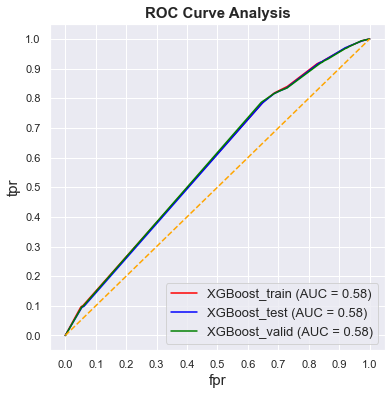

In [86]:
# Plot the figure:
fig, ax = plt.subplots(figsize=(6,6))

plot_roc_curve(xgb_model, X_train, y_train, color='red', ax=ax, name='XGBoost_train')
plot_roc_curve(xgb_model, X_test, y_test, color='blue', ax=ax, name='XGBoost_test')
plot_roc_curve(xgb_model, X_valid, y_valid, color='green', ax=ax, name='XGBoost_valid')
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("fpr", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("tpr", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

## Plotting

### Feature importance (data)

In [87]:
# Let's build a dictionary to better see each feature with its corresponding importance:
feature_importance_dict = dict(zip(X_train.columns, xgb_model.feature_importances_))
feature_importance_dict

{'TAXI_OUT_median': 0.013637457,
 'TAXI_IN_median': 0.0051010284,
 'CRS_ELAPSED_TIME': 0.0,
 'DISTANCE': 0.002075656,
 'MONTH_1': 0.0,
 'MONTH_2': 0.009572874,
 'MONTH_3': 0.0,
 'MONTH_4': 0.0,
 'MONTH_5': 0.0,
 'MONTH_6': 0.112481795,
 'MONTH_7': 0.0,
 'MONTH_8': 0.0016454313,
 'MONTH_9': 0.0,
 'MONTH_10': 0.002066719,
 'MONTH_11': 0.0,
 'MONTH_12': 0.0,
 'DAY_OF_MONTH_1': 0.0,
 'DAY_OF_MONTH_2': 0.0,
 'DAY_OF_MONTH_3': 0.0,
 'DAY_OF_MONTH_4': 0.0,
 'DAY_OF_MONTH_5': 0.0,
 'DAY_OF_MONTH_6': 0.0,
 'DAY_OF_MONTH_7': 0.0,
 'DAY_OF_MONTH_8': 0.0,
 'DAY_OF_MONTH_9': 0.0,
 'DAY_OF_MONTH_10': 0.0,
 'DAY_OF_MONTH_11': 0.0,
 'DAY_OF_MONTH_12': 0.0,
 'DAY_OF_MONTH_13': 0.0,
 'DAY_OF_MONTH_14': 0.0,
 'DAY_OF_MONTH_15': 0.0,
 'DAY_OF_MONTH_16': 0.0,
 'DAY_OF_MONTH_17': 0.0,
 'DAY_OF_MONTH_18': 0.0,
 'DAY_OF_MONTH_19': 0.0,
 'DAY_OF_MONTH_20': 0.0,
 'DAY_OF_MONTH_21': 0.0,
 'DAY_OF_MONTH_22': 0.0,
 'DAY_OF_MONTH_23': 0.0,
 'DAY_OF_MONTH_24': 0.0,
 'DAY_OF_MONTH_25': 0.0,
 'DAY_OF_MONTH_26': 0.0,
 

### Feature importance (plot)

#### Weight-based

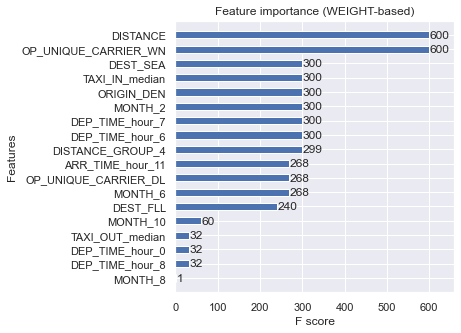

In [88]:
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(5,5))

plot_importance(booster=xgb_model,
                ax=ax,
                grid=True,
                importance_type='weight', # ”weight” is the number of times a feature appears in a tree
                max_num_features=None, 
                height=0.5,
                xlim=None,
                ylim=None, 
                title='Feature importance (WEIGHT-based)',
                xlabel='F score',
                ylabel='Features',
                show_values=True);

#### Gain-based

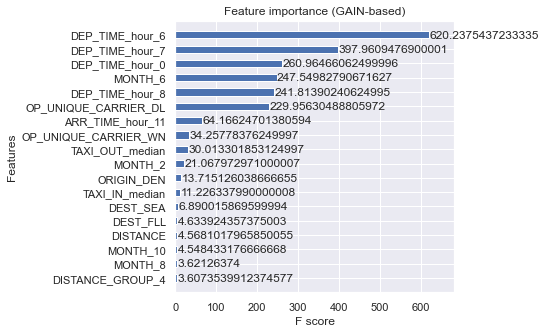

In [89]:
from xgboost import plot_importance

fig,ax = plt.subplots(figsize=(5,5))

plot_importance(booster=xgb_model,
                ax=ax,
                grid=True,
                importance_type='gain', # ”weight” is the number of times a feature appears in a tree
                max_num_features=None, 
                height=0.5,
                xlim=None,
                ylim=None, 
                title='Feature importance (GAIN-based)',
                xlabel='F score',
                ylabel='Features',
                show_values=True);

### Permutation Importances (`eli5` library)

- The values towards the top are the most important features, and those towards the bottom matter least.
- The first number in each row shows how much model performance decreases with a random shuffling (in this case, using "roc" as the performance metric).

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_model, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

### Partial Dependence Plot (PDP, `pdpbox` library)

In [ ]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data to plot:
pdp_delays = pdp.pdp_isolate(model=xgb_model, dataset=X_test, model_features=X_test.columns.tolist(), feature='DEP_TIME_hour_6')

# Plot it:
pdp.pdp_plot(pdp_delays, 'DEP_TIME_hour_6')

### Calculate and show Shap Values for One Prediction (`shap` library)

#### Single row Plot

In [ ]:
import shap

data_for_prediction = X_test.iloc[0,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

#### Summary Plots

`shap_values[1]` is called. For classification problems, there is a separate array of SHAP values for each possible outcome. In the example, the [1] index is to get the SHAP values for the prediction of "True".

Calculating SHAP values can be slow. However, SHAP has some optimizations for `xgboost` models, thus making it much faster to compute.

In [ ]:
# Create object that can calculate shap values:
explainer = shap.TreeExplainer(xgb_model)

# Calculate shap_values for all of val_X rather than a single row, to have more data for plot:
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test)

### Dependence Contribution Plots *(delve into a single feature)*

In [ ]:
# Make plot:
shap.dependence_plot('OP_UNIQUE_CARRIER', shap_values[1], X_train, interaction_index="OP_UNIQUE_CARRIER")
# shap.dependence_plot("rank(0)", shap_values, X) # "rank(i)": specify the i'th most important feature to the model

### Tree

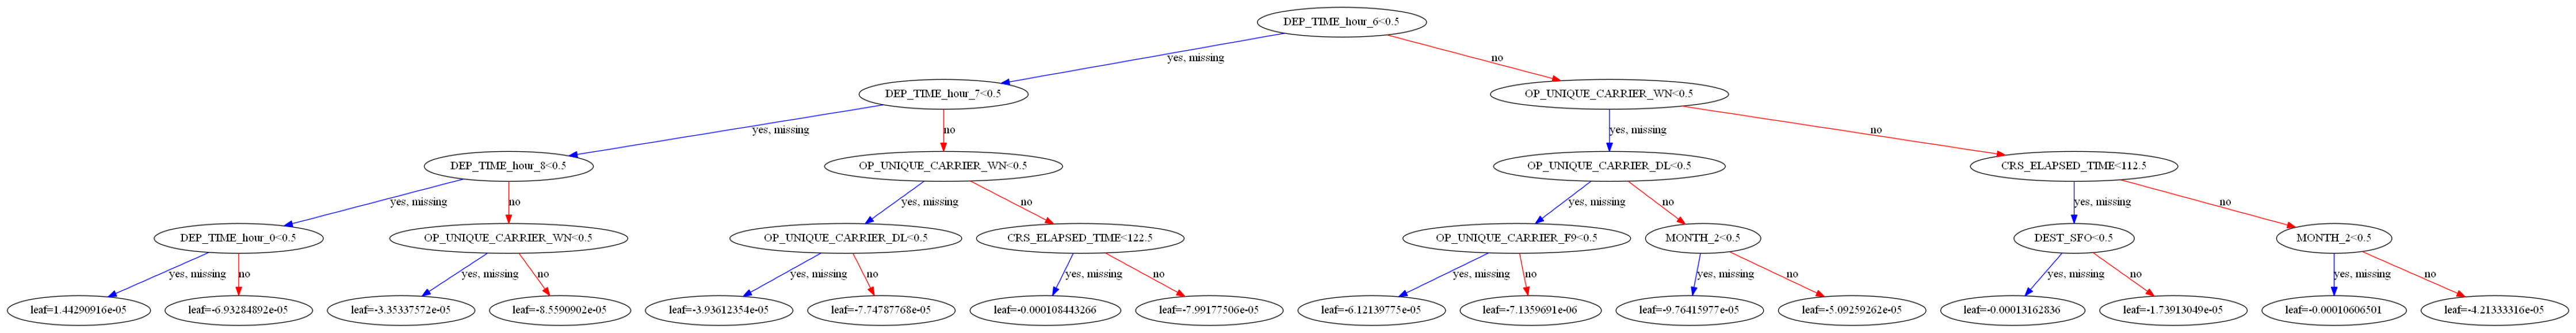

In [30]:
from xgboost import plot_tree

fig,ax = plt.subplots(figsize=(80,50))

plot_tree(booster=xgb_model,
          num_trees=0,
          ax=ax)

plt.savefig('plot_tree_14.png')

### Graphviz (tree)

*Convert specified tree to graphviz instance. IPython can automatically plot the returned graphiz instance. Otherwise, you should call `.render()` method of the returned graphiz instance.*

In [31]:
from xgboost import to_graphviz

tree_graphviz = to_graphviz(booster=xgb_model,
                            yes_color='#0000FF',
                            no_color='#FF0000',
                            condition_node_params={'shape': 'box',
                                                   'style': 'filled,rounded',
                                                   'fillcolor': '#78bceb'},
                            leaf_node_params={'shape': 'box',
                                              'style': 'filled',
                                              'fillcolor': '#e48038'})

format = 'png'
tree_graphviz = to_graphviz(xgb_model)
tree_graphviz.graph_attr = {'dpi':'400'}
tree_graphviz.render('tree_graphviz_14', format = format)

'tree_graphviz_14.png'

___

In [32]:
t1 = time.perf_counter() - t0
print("Time elapsed: {:2.0f}h {:2.0f}min {:2.0f}s".format(t1//3600, (t1%3600)//60, (t1%3600)%60))

Time elapsed:  1h  6min  7s


## Save the model

In [33]:
from joblib import dump, load

# Save model to file:
dump(xgb_model, "XGBoost_14.joblib.dat")
print("Saved model to: XGBoost_14.joblib.dat")

Saved model to: XGBoost_14.joblib.dat


In [34]:
# Load model from file:
loaded_model = load("XGBoost_14.joblib.dat")
print("Loaded model from: XGBoost_14.joblib.dat")

Loaded model from: XGBoost_14.joblib.dat


In [35]:
# Make predictions for test data
predictions = loaded_model.predict(X_test)

# Evaluate predictions:
recall = recall_score(y_test, predictions)
print("Loaded model recall: {:6.3f}".format(recall))

Loaded model recall:  0.858


___

___